<a href="https://colab.research.google.com/github/whistle-hikhi/Facial-Expression-Recognition-with-PyTorch/blob/main/Facial_Expression_Recognition_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/jonathanoheix/face-expression-recognition-dataset

In [1]:
!git clone https://github.com/parth1620/Facial-Expression-Dataset.git
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python ;

Cloning into 'Facial-Expression-Dataset'...
remote: Enumerating objects: 34052, done.
remote: Total 34052 (delta 0), reused 0 (delta 0), pack-reused 34052
Receiving objects: 100% (34052/34052), 52.31 MiB | 19.23 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Updating files: 100% (35887/35887), done.
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-18lk1v3_
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-18lk1v3_
  Resolved https://github.com/albumentations-team/albumentations to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-1.3.1-py3-none-any.whl size=125700 sha256=53105b67ae13c3658158c1c8a0d5c774d03ddc60daed1092172fd3b1642d577e
  Stored in directory: /tmp/pip-ephem-wheel-cache-2s5y_yf2/wheels/51/4d/ab/5aafa8b980086fbc362946de7da4aa3df33aacb3da0da29b93
Successfully bu

# Import

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Configurations

In [3]:
TRAIN_IMG_FOLDER_PATH = '/content/Facial-Expression-Dataset/train'
VALID_IMG_FOLDER_PATH = '/content/Facial-Expression-Dataset/validation'

LR = 0.001
BATCH_SIZE = 32
EPOCHS = 15

DEVICE = 'cuda'
MODEL_NAME = 'efficientnet_b0'


# Load Dataset

In [4]:
from torchvision.datasets import ImageFolder
from torchvision import transforms as T

In [5]:
train_augs = T.Compose([
        T.RandomHorizontalFlip(p=0.5),
        T.RandomRotation(degrees =(-20, +20)),
        T.ToTensor() #PIL numpy arr -> torch tensor ; (h, w, c) -> (c, h, w)
])

valid_augs = T.Compose([
        T.ToTensor()
])

In [6]:
trainset = ImageFolder(TRAIN_IMG_FOLDER_PATH, transform = train_augs)
validset = ImageFolder(VALID_IMG_FOLDER_PATH, transform = valid_augs)

In [7]:
print(f'Total no. of examples in trainset: {len(trainset)}')
print(f'Total no. of examples in validset: {len(validset)}')

Total no. of examples in trainset: 28821
Total no. of examples in validset: 7066


In [8]:
print(trainset.class_to_idx)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


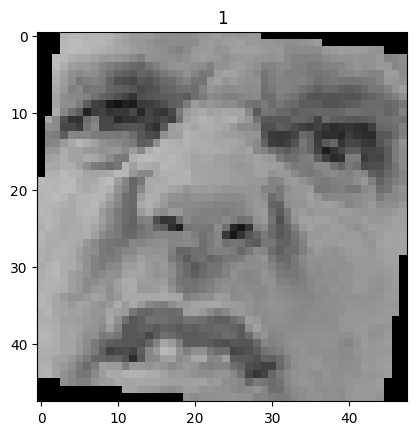

In [9]:
image, label = trainset[4000]

plt.imshow(image.permute(1, 2, 0)) #(h, w, c)
plt.title(label);

# Load Dataset into Batches

In [10]:
from torch.utils.data import DataLoader

In [11]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [12]:
print(f"Total no. of batches in trainloader : {len(trainloader)}")
print(f"Total no. of batches in validloader : {len(validloader)}")

Total no. of batches in trainloader : 901
Total no. of batches in validloader : 221


In [13]:
for images, labels in trainloader:
    break;

print(f"One image batch shape : {images.shape}")
print(f"One label batch shape : {labels.shape}")

One image batch shape : torch.Size([32, 3, 48, 48])
One label batch shape : torch.Size([32])


# Create Model

In [14]:
import timm
from torch import nn

In [15]:
class FaceModel(nn.Module):
    def __init__(self):
        super(FaceModel, self).__init__()

        self.eff_net = timm.create_model('efficientnet_b0', pretrained = True, num_classes = 7)

    def forward(self, images, labels = None):

        logits = self.eff_net(images)

        if labels != None:
            loss = nn.CrossEntropyLoss()(logits, labels)
            return logits, loss

        return logits

In [16]:
model = FaceModel()
model.to(DEVICE)

FaceModel(
  (eff_net): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 

# Create Train and Eval Function

In [17]:
from tqdm import tqdm

In [18]:
def multiclass_accuracy(y_pred,y_true):
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [25]:
def train_fn(model, dataloader, optimizer, current_epo):

    model.train()
    total_loss = 0.0
    total_acc = 0.0
    tk = tqdm(dataloader, desc = "EPOCH" + "[TRAIN]" + str(current_epo + 1) + "/" + str(EPOCHS))
    for t, data in enumerate(tk):
      images, labels = data
      images, labels = images.to(DEVICE), labels.to(DEVICE)

      optimizer.zero_grad()
      logits, loss = model(images, labels)
      loss.backward()
      optimizer.step()

      total_loss += loss.item()
      total_acc += multiclass_accuracy(logits, labels)
      tk.set_postfix({'loss': '%6f' %float(total_loss / (t+1)),'acc': '%6f' %float(total_acc / (t+1)) })

    return total_loss / len(dataloader), total_acc / len(dataloader)

In [26]:
def eval_fn(model, dataloader, current_epo):

    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    tk = tqdm(dataloader, desc = "EPOCH" + "[TRAIN]" + str(current_epo + 1) + "/" + str(EPOCHS))
    for t, data in enumerate(tk):
      images, labels = data
      images, labels = images.to(DEVICE), labels.to(DEVICE)

      logits, loss = model(images, labels)

      total_loss += loss.item()
      total_acc += multiclass_accuracy(logits, labels)
      tk.set_postfix({'loss': '%6f' %float(total_loss / (t+1)),'acc': '%6f' %float(total_acc / (t+1)) })

    return total_loss / len(dataloader), total_acc / len(dataloader)

# Create Traning Loop

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr= LR)

In [27]:
best_valid_loss = np.Inf
for i in range(EPOCHS):
    train_loss, train_acc = train_fn(model, trainloader, optimizer, i)
    valid_loss, valid_acc = eval_fn(model, validloader, i)

    if valid_loss < best_valid_loss:
      torch.save(model.state_dict(), 'best_weights.pt')
      print('SAVED BEST WEIGHTS')
      best_valid_loss = valid_loss

EPOCH[TRAIN]1/15: 100%|██████████| 221/221 [00:06<00:00, 32.99it/s, loss=1.357705, acc=0.473199]


SAVED BEST WEIGHTS


EPOCH[TRAIN]2/15: 100%|██████████| 221/221 [00:05<00:00, 37.50it/s, loss=1.199400, acc=0.550154]


SAVED BEST WEIGHTS


EPOCH[TRAIN]3/15: 100%|██████████| 221/221 [00:05<00:00, 36.98it/s, loss=1.112273, acc=0.580023]


SAVED BEST WEIGHTS


EPOCH[TRAIN]4/15: 100%|██████████| 221/221 [00:06<00:00, 33.43it/s, loss=1.087765, acc=0.584233]


SAVED BEST WEIGHTS


EPOCH[TRAIN]5/15: 100%|██████████| 221/221 [00:09<00:00, 23.29it/s, loss=1.074301, acc=0.590759]


SAVED BEST WEIGHTS


EPOCH[TRAIN]6/15: 100%|██████████| 221/221 [00:05<00:00, 37.02it/s, loss=1.042376, acc=0.611937]


SAVED BEST WEIGHTS


EPOCH[TRAIN]8/15: 100%|██████████| 221/221 [00:06<00:00, 33.92it/s, loss=1.001456, acc=0.622694]


SAVED BEST WEIGHTS


EPOCH[TRAIN]10/15: 100%|██████████| 221/221 [00:05<00:00, 37.96it/s, loss=0.993376, acc=0.636976]


SAVED BEST WEIGHTS


EPOCH[TRAIN]14/15: 100%|██████████| 221/221 [00:05<00:00, 38.16it/s, loss=0.962445, acc=0.650474]


SAVED BEST WEIGHTS


EPOCH[TRAIN]15/15: 100%|██████████| 221/221 [00:05<00:00, 38.02it/s, loss=1.006026, acc=0.639184]


# Inference

In [28]:
def view_classify(img, ps):

    classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

    ps = ps.data.cpu().numpy().squeeze()
    img = img.numpy().transpose(1,2,0)

    fig, (ax1, ax2) = plt.subplots(figsize=(5,9), ncols=2)
    ax1.imshow(img)
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None

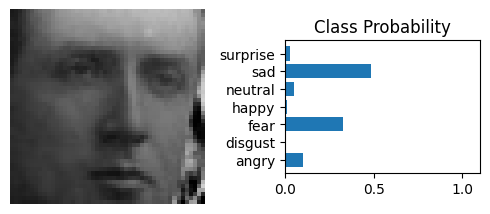

In [31]:
image, label = validset[100]
image = image.unsqueeze(0)

logits = model(image.to(DEVICE))
probs = nn.Softmax(dim = 1)(logits)

view_classify(image.squeeze(), probs)